<a href="https://colab.research.google.com/github/MohamedAhmed35/computer-vision/blob/main/object-detection/R-CNN/cat_dog_detection/03_RCNN_cat_dog_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog detection Using R-CNN from Scratch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import matplotlib.pyplot as plt

import warnings, sys, os
# Suppress all warnings
warnings.filterwarnings("ignore")

sys.path.append('/content/drive/MyDrive/Colab Notebooks/R-CNN')
import helper_functions as helper

%matplotlib inline

In [3]:
def draw_bounding_box(output_img, curr_idx, class_labels, adjustment_params, scores, boxes, adjust_bbox):
    """
    Draws the bounding box on the output image based on the current index.

    Parameters:
        output_img (numpy.ndarray): The image on which to draw the bounding box.
        curr_idx (int): The index of the current box to draw.
        class_labels (list): List of class labels for the boxes.
        adjustment_params (list): List of adjustment parameters for the boxes.
        scores (list): List of scores for the boxes.
        boxes (list): List of bounding box coordinates.
        adjust_bbox (bool): Flag indicating whether to adjust the bounding box.

    Returns:
        None: The function modifies the output image in place.
    """
    # Get class label, adjustment parameters, score, and bounding box for the current index
    curr_class_label = class_labels[curr_idx]
    params = adjustment_params[curr_idx]
    curr_score = scores[curr_idx]
    curr_box = boxes[curr_idx]

    # Adjust the bounding box if the adjust_bbox flag is set to True
    if adjust_bbox:
        x1_prime, y1_prime, x2_prime, y2_prime = helper.adjust_bounding_box(curr_box, params)

        # Draw the adjusted bounding box on the output image
        color = (0, 0, 255)  # Red for adjusted boxes
        cv2.rectangle(output_img, (x1_prime, y1_prime), (x2_prime, y2_prime), color, 1)
    else:
        # Draw the original bounding box on the output image
        x1, y1, x2, y2 = curr_box
        color = (255, 0, 0)  # Blue for original boxes
        cv2.rectangle(output_img, (x1, y1), (x2, y2), color, 1)

    # Put the class label and score text on the image
    text_position = (x1_prime if adjust_bbox else x1, y1_prime - 4 if adjust_bbox else y1 - 4)
    cv2.putText(output_img, f"{curr_class_label}: {curr_score:.2f}", text_position,
                cv2.FONT_HERSHEY_PLAIN, 0.5, (255, 255, 255), 1)

In [4]:
def objects_detection(image_path, num_regions = 50, adjust_bbox = False, NMS = False, iou_threshold = 0.5):
    """
    Performs object detection on only cats and/or dogs in an image

    Args:
        image_path (str): Path to the image file on which object detection needs to be performed.
        num_regions (int): The maximum number of region proposals to generate for the object detection.
        adjust_bbox (bool): A flag indicating whether to apply transformation parameters to adjust the bounding boxes based on the detection model's output.
        NMS (bool): A flag indicating whether to apply Non-Maximum Suppression (NMS) to filter out overlapping bounding boxes.
        iou_threshold (float): The IoU threshold used for NMS. Boxes with an IoU greater than this threshold will be suppressed.

    Returns:
        None: The function displays the processed images using matplotlib.

    Raises:
        FileNotFoundError:
            If the provided image_path does not point to a valid image file.

        TypeError:
            If any of the parameters do not match their expected types.
    """

    # Check if the image path exists; if not, raise an error
    if not os.path.exists(image_path):
        raise FileNotFoundError("The image path not exists. Provide a valid path")

    # Verify that num_regions is an integer
    if not isinstance(num_regions, int):
        raise TypeError("'num_regions' must be int values.")

   # Verify that adjust_bbox is a boolean
    if not isinstance(adjust_bbox, bool):
        raise TypeError(f"Expected 'adjust_bbox' to be a boolean, but got {type(adjust_bbox).__name__}")

    # Verify that NMS is a boolean
    if not isinstance(NMS, bool):
        raise TypeError(f"Expected 'NMS' to be a boolean, but got {type(NMS).__name__}")

    # Verify that iou_threshold is a float
    if not isinstance(iou_threshold, float):
        raise TypeError(f"'iou_threshold' must be a float value, but got {type(iou_threshold).__name__}")

    # Read the image from the specified path
    img = cv2.imread(image_path)

    # Resize the image to the expected input size for the model (224x224 here)
    img_resized = cv2.resize(img, (224, 224))

    # Convert the image to RGB format (OpenCV loads images in BGR by default)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Generate region proposals using selective search
    pred_bboxes, regions = helper.selectiveSearch(img_resized, num_regions)

    # Create a copy of the RGB image for displaying results
    img_copy = img_rgb.copy()

    # Process the proposed regions to get bounding boxes, scores, class labels, and adjustment params
    boxes, scores, class_labels, adjustment_params = helper.process_image_regions(regions, pred_bboxes, img_copy)

    # Prepare images for displaying results before and after adjustments
    output_img = img_rgb.copy()

    # If NMS is requested, apply it to filter overlapping boxes
    if NMS:
        selected_indices = helper.non_maximum_suppression(boxes, scores, iou_threshold)

        # Iterate through the selected indices from NMS
        for curr_idx in selected_indices:
            draw_bounding_box(output_img, curr_idx, class_labels, adjustment_params, scores, boxes, adjust_bbox)
    else:
        # If NMS is not requested, process all boxes directly
        for box_idx, curr_box in enumerate(boxes):
            draw_bounding_box(output_img, box_idx, class_labels, adjustment_params, scores, boxes, adjust_bbox)

    # Plot the output_img
    plt.imshow(output_img)
    plt.axis('off')  # Turn off axis

    # Show the plot
    plt.show()

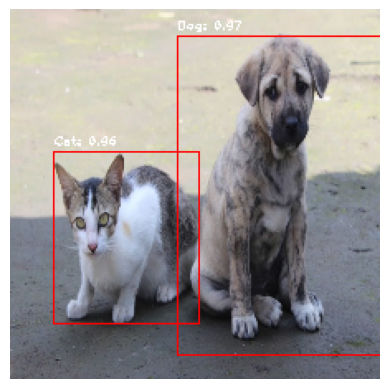

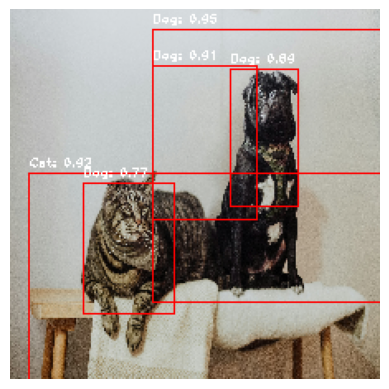

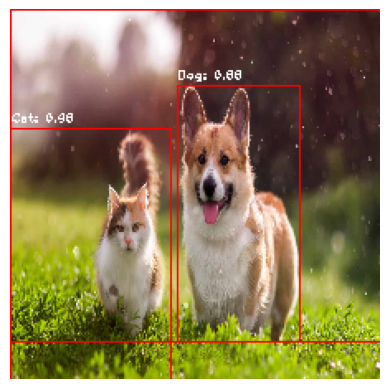

In [5]:
test_images = ["/content/drive/MyDrive/Colab Notebooks/R-CNN/images/cat_dog.png",
               "/content/drive/MyDrive/Colab Notebooks/R-CNN/images/cat_dog_1.jpg",
               "/content/drive/MyDrive/Colab Notebooks/R-CNN/images/cat_dog_3.jpg"]

for test_img in test_images:
    # Increasing the num_regions and lowering iou_threshold give better results.
    objects_detection(test_img, num_regions=500, NMS = True, iou_threshold=0.3)